**Introduction**

This is a Google Colab Notebook which trains a X3D model (using pytorchvideo) on a dataset of videos. The dataset's directory should have 3 sub-directories, one for "train", "val", and "test". In each of these directories should be more directories, named with the dataset's classes. Then, within each of these directories should be videos, whose label corresponds to the directory they are placed in (e.g. dataset->train->archery->archery_1.mph).

The "Set-up" section is used for downloading necessary packages and intiliazing variables. Take a look at the variables (such as file paths), and change them accordingly.

The "Focal Loss and Dataset Distribution" section has code that finds distribution of the used dataset and uses the information to set up Focal Loss.

The "Class Creation for Dataloaders" section creates the classes/objects necessary for creating and using dataloaders later in the process. Within this section is a commented code block which would change the transform function to one of a resnet. Uncommenting this code block, and changing the model to "make_resnet" in "Model Creation" would use a resnet50 instead.

The "Model Creation" section creates the object that is used as the Lightning Module for the model.

The "Training" section trains the model using the Trainer from Pytorch Lightning.

The "Testing" section tests the model using Trainer.test.

The "TSNE" section makes a TSNE.

The "Testing 2" section uses a script that manually tests every file in the test dataset.

# Set-up


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%load_ext tensorboard

In [ ]:
!pip install pytorchvideo
!pip install pytorch_lightning

In [ ]:
import os
import pytorch_lightning
import pytorchvideo.data
import torch.utils.data
import torchvision
import pytorchvideo
import pytorchvideo.transforms
from torch.nn.functional import softmax
from typing import Dict
import json
import urllib
from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample,
    UniformCropVideo
)
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip
)
import sklearn
#from sklearn.metrics import accuracy_score

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


In [ ]:
input_dir = '/content/drive/MyDrive/Research/Muscle Video/Datasets/split_workout_videos_v1'
model_name = 'x3d_s'
checkpoint_path = '/content/drive/MyDrive/Research/Muscle Video/Checkpoints/x3d/' + model_name + '/pretrained'

num_classes=16
batch_size = 8
num_workers = 12
mean = [0.45, 0.45, 0.45]
std = [0.225, 0.225, 0.225]
model_transform_params  = {
    "x3d_xs": {
        "side_size": 182,
        "crop_size": 182,
        "num_frames": 4,
        "sampling_rate": 12,
    },
    "x3d_s": {
        "side_size": 182,
        "crop_size": 182,
        "num_frames": 13,
        "sampling_rate": 6,
    },
    "x3d_m": {
        "side_size": 256,
        "crop_size": 256,
        "num_frames": 16,
        "sampling_rate": 5,
    }
}
transform_params = model_transform_params[model_name]
frames_per_second = 30
slowfast_alpha = 4
clip_duration = (transform_params["num_frames"] * transform_params["sampling_rate"])/frames_per_second
device=('cuda' if torch.cuda.is_available() else 'cpu')
pretrained=False
learning_rate=0.0001
dropout_rate = 0.7
gamma = 2

In [ ]:
import multiprocessing

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

12

In [ ]:
'''
pred_to_class = {
    0: "barbell biceps curl",
    1: "bench press",
    2: "chest fly machine",
    3: "deadlift",
    4: "decline bench press",
    5: "hammer curl",
    6: "hip thrust",
    7: "incline bench press",
    8: "lat pulldown",
    9: "lateral raise",
    10: "leg extension",
    11: "leg raises",
    12: "plank",
    13: "pull Up",
    14: "push-up",
    15: "romanian deadlift",
    16: "russian twist",
    17: "shoulder press",
    18: "squat",
    19: "t bar row",
    20: "tricep Pushdown",
    21: "tricep dips"
}
'''
pred_to_class = {
    0: "bench press",
    1: "bicep curl",
    2: "chest fly machine",
    3: "deadlift",
    4: "hip thrust",
    5: "lat pulling",
    6: "lateral raise",
    7: "leg extension",
    8: "leg raises",
    9: "push-up",
    10: "russian twist",
    11: "shoulder press",
    12: "squat",
    13: "t bar row",
    14: "tricep Pushdown",
    15: "tricep dips"
}

# Focal Loss and Dataset Distribution



In [ ]:
dataset = input_dir

In [ ]:
train_class_values = {}
test_class_values = {}
for split in os.listdir(dataset):
  new_path = os.path.join(dataset, split)
  for classname in os.listdir(new_path):
    class_path = os.path.join(new_path, classname)
    num_samples = len(os.listdir(class_path))
    print("In the", split, "split, for the", classname, "class, there are", num_samples, "samples.")
    if split=="train":
      train_class_values[classname] = num_samples
    if split=="test":
      test_class_values[classname] = num_samples

In the train split, for the bench press class, there are 183 samples.
In the train split, for the lateral raise class, there are 67 samples.
In the train split, for the chest fly machine class, there are 49 samples.
In the train split, for the hip thrust class, there are 55 samples.
In the train split, for the deadlift class, there are 129 samples.
In the train split, for the leg extension class, there are 53 samples.
In the train split, for the push-up class, there are 78 samples.
In the train split, for the squat class, there are 77 samples.
In the train split, for the leg raises class, there are 43 samples.
In the train split, for the t bar row class, there are 60 samples.
In the train split, for the shoulder press class, there are 42 samples.
In the train split, for the russian twist class, there are 53 samples.
In the train split, for the tricep Pushdown class, there are 40 samples.
In the train split, for the tricep dips class, there are 72 samples.
In the train split, for the bi

In [ ]:
train_class_values

{'bench press': 183,
 'lateral raise': 67,
 'chest fly machine': 49,
 'hip thrust': 55,
 'deadlift': 129,
 'leg extension': 53,
 'push-up': 78,
 'squat': 77,
 'leg raises': 43,
 't bar row': 60,
 'shoulder press': 42,
 'russian twist': 53,
 'tricep Pushdown': 40,
 'tricep dips': 72,
 'bicep curl': 106,
 'lat pulling': 111}

In [ ]:
test_class_values

{'bench press': 37,
 'lateral raise': 33,
 'chest fly machine': 18,
 'hip thrust': 15,
 'deadlift': 49,
 'leg extension': 20,
 'push-up': 38,
 'squat': 39,
 'leg raises': 17,
 't bar row': 28,
 'shoulder press': 23,
 'russian twist': 19,
 'tricep Pushdown': 17,
 'tricep dips': 25,
 'bicep curl': 30,
 'lat pulling': 34}

In [ ]:
total = 0
for classname in train_class_values:
  total = total + train_class_values[classname]

In [ ]:
total

1218

In [ ]:
total_test = 0
for classname in test_class_values:
  total_test = total_test + test_class_values[classname]

In [ ]:
total_test

442

In [ ]:
class_weights = {}
for classname in train_class_values:
  weight = 1 / (train_class_values[classname] / total)
  class_weights[classname] = weight

In [ ]:
class_weights

{'bench press': 6.655737704918033,
 'lateral raise': 18.17910447761194,
 'chest fly machine': 24.857142857142858,
 'hip thrust': 22.145454545454545,
 'deadlift': 9.44186046511628,
 'leg extension': 22.981132075471695,
 'push-up': 15.615384615384615,
 'squat': 15.818181818181817,
 'leg raises': 28.325581395348838,
 't bar row': 20.3,
 'shoulder press': 29.0,
 'russian twist': 22.981132075471695,
 'tricep Pushdown': 30.45,
 'tricep dips': 16.916666666666668,
 'bicep curl': 11.490566037735848,
 'lat pulling': 10.972972972972974}

In [ ]:
class_to_int = {}
for i in pred_to_class:
  class_to_int[pred_to_class[i]]=i

In [ ]:
class_to_int

{'bench press': 0,
 'bicep curl': 1,
 'chest fly machine': 2,
 'deadlift': 3,
 'hip thrust': 4,
 'lat pulling': 5,
 'lateral raise': 6,
 'leg extension': 7,
 'leg raises': 8,
 'push-up': 9,
 'russian twist': 10,
 'shoulder press': 11,
 'squat': 12,
 't bar row': 13,
 'tricep Pushdown': 14,
 'tricep dips': 15}

In [ ]:
list_weights = [None] * num_classes
for i in class_weights:
  list_weights[class_to_int[i]] = class_weights[i]
list_weights

[6.655737704918033,
 11.490566037735848,
 24.857142857142858,
 9.44186046511628,
 22.145454545454545,
 10.972972972972974,
 18.17910447761194,
 22.981132075471695,
 28.325581395348838,
 15.615384615384615,
 22.981132075471695,
 29.0,
 15.818181818181817,
 20.3,
 30.45,
 16.916666666666668]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from torchvision.ops.focal_loss import sigmoid_focal_loss

In [ ]:
#focal_loss = sigmoid_focal_loss(alpha=class_weights, gamma=2)

# Class Creation for Dataloaders

In [ ]:

import pytorchvideo.models.x3d

def post_act(input):
  return softmax(input, dim=1)

'''
def make_x3d():
    return pytorchvideo.models.x3d.create_x3d(
        input_channel=3,
        input_clip_length=clip_duration,
        input_crop_size=transform_params["crop_size"],
        model_num_class=num_classes,
        norm=nn.BatchNorm3d,
        activation=nn.ReLU,
        dropout_rate=dropout_rate,
    )
'''

transform =  ApplyTransformToKey(
    key="video",
    transform=Compose(
        [
            UniformTemporalSubsample(transform_params["num_frames"]),
            Lambda(lambda x: x/255.0),
            NormalizeVideo(mean, std),
            ShortSideScale(size=transform_params["side_size"]),
            CenterCropVideo(
                crop_size=(transform_params["crop_size"], transform_params["crop_size"])
            )
        ]
    ),
)


In [ ]:
class VideosDataModule(pytorch_lightning.LightningDataModule):

    # Dataset configuration
    _DATA_PATH = input_dir
    _CLIP_DURATION = clip_duration  # Duration of sampled clip for each video
    _BATCH_SIZE = batch_size
    _NUM_WORKERS = num_workers  # Number of parallel processes fetching data

    def train_dataloader(self):
        #Create the train partition from the list of video labels and video paths
        train_dataset = pytorchvideo.data.labeled_video_dataset(
            data_path=os.path.join(self._DATA_PATH, 'train'),
            clip_sampler=pytorchvideo.data.make_clip_sampler("random", self._CLIP_DURATION),
            decode_audio=False,
            transform=transform
        )

        return torch.utils.data.DataLoader(
            train_dataset,
            batch_size=self._BATCH_SIZE,
            num_workers=self._NUM_WORKERS
        )

    def val_dataloader(self):
        #Create the validation partition from the list of video labels and video paths
        val_dataset = pytorchvideo.data.labeled_video_dataset(
            data_path=os.path.join(self._DATA_PATH, 'val'),
            clip_sampler=pytorchvideo.data.make_clip_sampler("random", self._CLIP_DURATION),
            decode_audio=False,
            transform=transform
        )

        return torch.utils.data.DataLoader(
            val_dataset,
            batch_size=self._BATCH_SIZE,
            num_workers=self._NUM_WORKERS,
        )

    def test_dataloader(self):
        test_dataset = pytorchvideo.data.labeled_video_dataset(
            data_path=os.path.join(self._DATA_PATH, 'test'),
            clip_sampler=pytorchvideo.data.make_clip_sampler("random", self._CLIP_DURATION),
            decode_audio=False,
            transform=transform
        )

        return torch.utils.data.DataLoader(
            test_dataset,
            batch_size=self._BATCH_SIZE,
            num_workers=self._NUM_WORKERS,
        )

# Model Creation


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchmetrics.classification import MulticlassAccuracy
from torch.nn import Linear
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

mca1 = MulticlassAccuracy(num_classes=num_classes, average='micro', top_k=1)
mca5 = MulticlassAccuracy(num_classes=num_classes, average='micro', top_k=5)

class VideoClassificationLightningModule(pytorch_lightning.LightningModule):

    def __init__(self):
        super().__init__()

        self.model = torch.hub.load('facebookresearch/pytorchvideo', model_name, pretrained=True)
        self.model.to(device)
        self.model.blocks[5].proj = Linear(in_features=2048, out_features=num_classes, bias=True)
        self.model.train()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        # The model expects a video tensor of shape (B, C, T, H, W), which is the
        # format provided by the dataset
        y_hat = self.model(batch["video"])

        # Compute cross entropy loss, loss.backwards will be called behind the scenes
        # by PyTorchLightning after being returned from this method.

        loss = F.cross_entropy(y_hat, batch["label"])

        # Log the train loss to Tensorboard
        self.log("train_loss", loss.item(), batch_size=batch_size)

        acc1 = mca1(y_hat.cpu(), batch["label"].cpu())
        acc5 = mca5(y_hat.cpu(), batch["label"].cpu())
        self.log("train_accuracy_top_1", acc1.item(), batch_size=batch_size)
        self.log("train_accuracy_top_5", acc5.item(), batch_size=batch_size)

        print("train_loss:", loss.item(), "train_accuracy_top_1:", acc1.item(), "train_accuracy_top_5:", acc5.item())

        return loss

    def validation_step(self, batch, batch_idx):
        y_hat = self.model(batch["video"])
        loss = F.cross_entropy(y_hat, batch["label"])

        self.log("val_loss", loss.item(), batch_size=batch_size)

        acc1 = mca1(y_hat.cpu(), batch["label"].cpu())
        acc5 = mca5(y_hat.cpu(), batch["label"].cpu())
        self.log("val_accuracy_top_1", acc1.item(), batch_size=batch_size)
        self.log("val_accuracy_top_5", acc5.item(), batch_size=batch_size)

        print("val_loss:", loss.item(), "val_accuracy_top_1:", acc1.item(), "val_accuracy_top_5:", acc5.item())

        return loss

    def configure_optimizers(self):
        """
        Setup the Adam optimizer. Note, that this function also can return a lr scheduler, which is
        usually useful for training video models.
        """
        return torch.optim.Adam(self.parameters(), lr=learning_rate)

    def test_step(self, batch, batch_idx):
        y_hat = self.model(batch["video"])
        loss = F.cross_entropy(y_hat, batch["label"])

        # logs metrics for each testing_step,
        # and the average across the epoch, to the progress bar and logger
        self.log("test_loss", loss.item(), batch_size=batch_size)

        acc1 = mca1(y_hat.cpu(), batch["label"].cpu())
        acc5 = mca5(y_hat.cpu(), batch["label"].cpu())
        self.log("test_accuracy_top_1", acc1.item(), batch_size=batch_size)
        self.log("test_accuracy_top_5", acc5.item(), batch_size=batch_size)

        softed = post_act(y_hat)
        auc = roc_auc_score(y_true=batch["label"].cpu(), y_score=softed.cpu(), multi_class='ovr', average='micro', labels=np.arange(num_classes))
        self.log("auc", auc, batch_size=batch_size)

        pred_classes = []
        for x in softed:
          class_index = x.topk(k=1).indices
          class_index = class_index[0]
          pred_classes.append(class_index)
        pred_classes = torch.Tensor(pred_classes)

        rpf1 = precision_recall_fscore_support(y_true=batch["label"].cpu(), y_pred=pred_classes.cpu(), beta=1, labels=np.arange(num_classes), average='macro', zero_division=1)
        precision = rpf1[0]
        recall = rpf1[1]
        f1 = rpf1[2]
        self.log("precision", precision, batch_size=batch_size)
        self.log("recall", recall, batch_size=batch_size)
        self.log("f1", f1, batch_size=batch_size)

        print("test_loss:", loss.item(), "test_accuracy_top_1:", acc1.item(), "test_accuracy_top_5:", acc5.item(), "auc:", auc, "precision:", precision, "recall:", recall, "f1:", f1)

        return loss

# Training

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping

early_stopping_callbacks = EarlyStopping(monitor="val_loss", min_delta=0, patience=30, verbose=True, mode="min")

In [ ]:
classification_module = VideoClassificationLightningModule()
data_module = VideosDataModule()
trainer = pytorch_lightning.Trainer(
    default_root_dir=checkpoint_path,
    max_epochs=30,
    accelerator="auto",
    devices="auto",
    strategy='auto',
    enable_checkpointing=True,
    logger=True,
)
#    callbacks=[early_stopping_callbacks],

Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
torch.set_float32_matmul_precision('medium')

In [ ]:
trainer.fit(classification_module, data_module, ckpt_path='/content/drive/MyDrive/Research/Muscle Video/Checkpoints/x3d/x3d_s/not pretrained/lightning_logs/version_0/checkpoints/epoch=7-step=1024.ckpt')

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Research/Muscle Video/Checkpoints/x3d/x3d_s/not pretrained/lightning_logs/version_0/checkpoints/epoch=7-step=1024.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:347: The dirpath has changed from '/content/drive/MyDrive/Research/Muscle Video/Checkpoints/x3d/x3d_s/not pretrained/lightning_logs/version_0/checkpoints' to '/content/drive/MyDrive/Research/Muscle Video/Checkpoints/x3d/x3d_s/not pretrained/lightning_logs/version_1/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | Net  | 3.0 M 
-----------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

val_loss: 2.621645450592041 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.375
val_loss: 2.8680529594421387 val_accuracy_top_1: 0.0 val_accuracy_top_5: 0.375


Training: |          | 0/? [00:00<?, ?it/s]

train_loss: 2.374650001525879 train_accuracy_top_1: 0.625 train_accuracy_top_5: 0.625
train_loss: 2.601346969604492 train_accuracy_top_1: 0.25 train_accuracy_top_5: 0.375
train_loss: 2.61275315284729 train_accuracy_top_1: 0.25 train_accuracy_top_5: 0.25
train_loss: 2.5284953117370605 train_accuracy_top_1: 0.375 train_accuracy_top_5: 0.5
train_loss: 2.5855588912963867 train_accuracy_top_1: 0.25 train_accuracy_top_5: 0.625
train_loss: 2.494152069091797 train_accuracy_top_1: 0.375 train_accuracy_top_5: 0.625
train_loss: 2.4961330890655518 train_accuracy_top_1: 0.375 train_accuracy_top_5: 0.375
train_loss: 2.621046543121338 train_accuracy_top_1: 0.25 train_accuracy_top_5: 0.5
train_loss: 2.7429699897766113 train_accuracy_top_1: 0.125 train_accuracy_top_5: 0.5
train_loss: 2.1964311599731445 train_accuracy_top_1: 0.75 train_accuracy_top_5: 0.75
train_loss: 2.381800413131714 train_accuracy_top_1: 0.5 train_accuracy_top_5: 0.875
train_loss: 2.6504924297332764 train_accuracy_top_1: 0.25 train_a

Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 2.627197742462158 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.375
val_loss: 2.766608953475952 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.375
val_loss: 2.852590322494507 val_accuracy_top_1: 0.0 val_accuracy_top_5: 0.25
val_loss: 2.659963607788086 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.375
val_loss: 2.7775394916534424 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.25
val_loss: 2.4982824325561523 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.5
val_loss: 2.440298080444336 val_accuracy_top_1: 0.5 val_accuracy_top_5: 0.75
val_loss: 2.6261627674102783 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.5
val_loss: 2.814058542251587 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.625
val_loss: 2.619767904281616 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.375
val_loss: 2.3774631023406982 val_accuracy_top_1: 0.5 val_accuracy_top_5: 0.5
val_loss: 2.8398823738098145 val_accuracy_top_1: 0.0 val_accuracy_top_5: 0.75
val_loss: 2.6952810287475586 val_accuracy_top_1: 0.125 va

Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 2.8189187049865723 val_accuracy_top_1: 0.0 val_accuracy_top_5: 0.125
val_loss: 2.612018585205078 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.5
val_loss: 2.6057159900665283 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.5
val_loss: 2.7829949855804443 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.5
val_loss: 2.700965642929077 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.375
val_loss: 2.5000696182250977 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.375
val_loss: 2.61651873588562 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.5
val_loss: 2.5952110290527344 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.75
val_loss: 2.5382540225982666 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.375
val_loss: 2.741137981414795 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.375
val_loss: 2.624446392059326 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.25
val_loss: 2.371004343032837 val_accuracy_top_1: 0.5 val_accuracy_top_5: 0.625
val_loss: 2.5936245918273926 val_accuracy_top_1: 0.25 

Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 2.7006256580352783 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.25
val_loss: 2.4253578186035156 val_accuracy_top_1: 0.5 val_accuracy_top_5: 0.75
val_loss: 2.3856163024902344 val_accuracy_top_1: 0.5 val_accuracy_top_5: 0.75
val_loss: 2.75563907623291 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.375
val_loss: 2.615764617919922 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.625
val_loss: 2.7415244579315186 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.25
val_loss: 2.775075912475586 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.5
val_loss: 2.719764232635498 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.375
val_loss: 2.771822452545166 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.5
val_loss: 2.7411227226257324 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.25
val_loss: 2.6728875637054443 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.25
val_loss: 2.720705270767212 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.5
val_loss: 2.4697325229644775 val_accuracy_top_1: 0.375

Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 2.7588086128234863 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.25
val_loss: 2.7856287956237793 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.375
val_loss: 2.276176691055298 val_accuracy_top_1: 0.625 val_accuracy_top_5: 0.625
val_loss: 2.519942283630371 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.625
val_loss: 2.83896541595459 val_accuracy_top_1: 0.0 val_accuracy_top_5: 0.25
val_loss: 2.4203269481658936 val_accuracy_top_1: 0.5 val_accuracy_top_5: 0.75
val_loss: 2.417388916015625 val_accuracy_top_1: 0.5 val_accuracy_top_5: 0.625
val_loss: 2.7806925773620605 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.25
val_loss: 2.7400259971618652 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.125
val_loss: 2.633068323135376 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.375
val_loss: 2.6138315200805664 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.625
val_loss: 2.489330291748047 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.625
val_loss: 2.5844063758850098 val_accuracy_top_1

Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 2.735299587249756 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.25
val_loss: 2.830470323562622 val_accuracy_top_1: 0.0 val_accuracy_top_5: 0.5
val_loss: 2.615971088409424 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.25
val_loss: 2.7338340282440186 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.25
val_loss: 2.462305784225464 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.625
val_loss: 2.6458892822265625 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.625
val_loss: 2.868054151535034 val_accuracy_top_1: 0.0 val_accuracy_top_5: 0.25
val_loss: 2.6138641834259033 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.375
val_loss: 2.6089062690734863 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.625
val_loss: 2.7401809692382812 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.375
val_loss: 2.7206664085388184 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.5
val_loss: 2.6440091133117676 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.25
val_loss: 2.578646659851074 val_accuracy_top_1: 0.2

Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 2.5169167518615723 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.5
val_loss: 2.73946475982666 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.625
val_loss: 2.675316095352173 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.375
val_loss: 2.5508530139923096 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.5
val_loss: 2.711439371109009 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.625
val_loss: 2.7403249740600586 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.375
val_loss: 2.560760021209717 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.5
val_loss: 2.3706202507019043 val_accuracy_top_1: 0.625 val_accuracy_top_5: 0.625
val_loss: 2.5600996017456055 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.5
val_loss: 2.505824565887451 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.375
val_loss: 2.469038486480713 val_accuracy_top_1: 0.5 val_accuracy_top_5: 0.625
val_loss: 2.7371912002563477 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.625
val_loss: 2.5355026721954346 val_accuracy_top_1: 0

Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 2.7891368865966797 val_accuracy_top_1: 0.0 val_accuracy_top_5: 0.75
val_loss: 2.5181686878204346 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.75
val_loss: 2.690585136413574 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.375
val_loss: 2.6077616214752197 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.375
val_loss: 2.551131248474121 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.75
val_loss: 2.6148884296417236 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.5
val_loss: 2.683824062347412 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.25
val_loss: 2.6981587409973145 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.625
val_loss: 2.623462677001953 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.375
val_loss: 2.7629141807556152 val_accuracy_top_1: 0.0 val_accuracy_top_5: 0.75
val_loss: 2.8431363105773926 val_accuracy_top_1: 0.0 val_accuracy_top_5: 0.75
val_loss: 2.2471206188201904 val_accuracy_top_1: 0.625 val_accuracy_top_5: 0.625
val_loss: 2.8579187393188477 val_accuracy_top_1: 

Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 2.5968687534332275 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.375
val_loss: 2.492326021194458 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.625
val_loss: 2.6401870250701904 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.375
val_loss: 2.4688572883605957 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.625
val_loss: 2.718156099319458 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.375
val_loss: 2.722264289855957 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.25
val_loss: 2.7365238666534424 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.375
val_loss: 2.576934576034546 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.75
val_loss: 2.496133327484131 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.75
val_loss: 2.7731688022613525 val_accuracy_top_1: 0.0 val_accuracy_top_5: 0.5
val_loss: 2.697544574737549 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.5
val_loss: 2.4771101474761963 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.625
val_loss: 2.6100194454193115 val_accuracy_top_

Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 2.6207902431488037 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.625
val_loss: 2.5377843379974365 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.75
val_loss: 2.8650834560394287 val_accuracy_top_1: 0.0 val_accuracy_top_5: 0.5
val_loss: 2.5148167610168457 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.625
val_loss: 2.601541757583618 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.375
val_loss: 2.6671152114868164 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.375
val_loss: 2.495110034942627 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.625
val_loss: 2.634218454360962 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.75
val_loss: 2.6789393424987793 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.625
val_loss: 2.4988150596618652 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.5
val_loss: 2.492257595062256 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.625
val_loss: 2.615398406982422 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.375
val_loss: 2.4870128631591797 val_accuracy_top_1

Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 2.6247153282165527 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.5
val_loss: 2.596200942993164 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.375
val_loss: 2.7253634929656982 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.25
val_loss: 2.8282999992370605 val_accuracy_top_1: 0.0 val_accuracy_top_5: 0.25
val_loss: 2.630418300628662 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.375
val_loss: 2.588176965713501 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.75
val_loss: 2.6182501316070557 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.375
val_loss: 2.6653897762298584 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.375
val_loss: 2.6085801124572754 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.5
val_loss: 2.619178533554077 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.375
val_loss: 2.7294483184814453 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.5
val_loss: 2.611452102661133 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.625
val_loss: 2.616506338119507 val_accuracy_top_1: 0.25

Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 2.4533517360687256 val_accuracy_top_1: 0.5 val_accuracy_top_5: 0.875
val_loss: 2.742043972015381 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.375
val_loss: 2.496046304702759 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.375
val_loss: 2.607248067855835 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.5
val_loss: 2.695486068725586 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.5
val_loss: 2.6498403549194336 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.5
val_loss: 2.494349718093872 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.375
val_loss: 2.4477710723876953 val_accuracy_top_1: 0.5 val_accuracy_top_5: 0.5
val_loss: 2.635709285736084 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.375
val_loss: 2.6100800037384033 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.625
val_loss: 2.5297863483428955 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.5
val_loss: 2.6096363067626953 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.375
val_loss: 2.2490482330322266 val_accuracy_top_1: 0.62

Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 2.736898899078369 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.375
val_loss: 2.5076451301574707 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.5
val_loss: 2.5025861263275146 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.75
val_loss: 2.491382122039795 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.75
val_loss: 2.5088717937469482 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.75
val_loss: 2.4857561588287354 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.75
val_loss: 2.7363483905792236 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.25
val_loss: 2.610201358795166 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.5
val_loss: 2.7502493858337402 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.625
val_loss: 2.6352035999298096 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.375
val_loss: 2.6352365016937256 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.375
val_loss: 2.71573543548584 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.5
val_loss: 2.6091837882995605 val_accuracy_top_1

Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 2.7345213890075684 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.25
val_loss: 2.621816396713257 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.625
val_loss: 2.6180100440979004 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.375
val_loss: 2.6358606815338135 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.5
val_loss: 2.6199727058410645 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.5
val_loss: 2.361309766769409 val_accuracy_top_1: 0.5 val_accuracy_top_5: 0.75
val_loss: 2.3338873386383057 val_accuracy_top_1: 0.5 val_accuracy_top_5: 0.875
val_loss: 2.694591522216797 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.375
val_loss: 2.537766456604004 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.5
val_loss: 2.8656671047210693 val_accuracy_top_1: 0.0 val_accuracy_top_5: 0.625
val_loss: 2.6423470973968506 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.875
val_loss: 2.6819751262664795 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.5
val_loss: 2.7306580543518066 val_accuracy_top_1: 0.125

Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 2.402729034423828 val_accuracy_top_1: 0.5 val_accuracy_top_5: 0.625
val_loss: 2.7783749103546143 val_accuracy_top_1: 0.0 val_accuracy_top_5: 0.5
val_loss: 2.5629844665527344 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.75
val_loss: 2.534435987472534 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.375
val_loss: 2.7023379802703857 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.375
val_loss: 2.481839895248413 val_accuracy_top_1: 0.5 val_accuracy_top_5: 0.75
val_loss: 2.7423744201660156 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.25
val_loss: 2.586829662322998 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.625
val_loss: 2.5968875885009766 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.75
val_loss: 2.5957562923431396 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.5
val_loss: 2.5870823860168457 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.5
val_loss: 2.3500826358795166 val_accuracy_top_1: 0.5 val_accuracy_top_5: 0.75
val_loss: 2.66142201423645 val_accuracy_top_1: 0.125 

Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 2.863516330718994 val_accuracy_top_1: 0.0 val_accuracy_top_5: 0.375
val_loss: 2.552729845046997 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.375
val_loss: 2.3989386558532715 val_accuracy_top_1: 0.5 val_accuracy_top_5: 0.625
val_loss: 2.6190669536590576 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.5
val_loss: 2.2578768730163574 val_accuracy_top_1: 0.625 val_accuracy_top_5: 0.75
val_loss: 2.734693765640259 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.125
val_loss: 2.1247284412384033 val_accuracy_top_1: 0.75 val_accuracy_top_5: 0.75
val_loss: 2.2546544075012207 val_accuracy_top_1: 0.625 val_accuracy_top_5: 0.875
val_loss: 2.7432055473327637 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.125
val_loss: 2.2453489303588867 val_accuracy_top_1: 0.625 val_accuracy_top_5: 0.875
val_loss: 2.730180025100708 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.25
val_loss: 2.4999802112579346 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.75
val_loss: 2.730441093444824 val_accuracy_top_

Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 2.5473175048828125 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.625
val_loss: 2.4838130474090576 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.75
val_loss: 2.6235220432281494 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.625
val_loss: 2.654475212097168 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.25
val_loss: 2.8342392444610596 val_accuracy_top_1: 0.0 val_accuracy_top_5: 0.625
val_loss: 2.508674383163452 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.625
val_loss: 2.6195383071899414 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.5
val_loss: 2.708731174468994 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.375
val_loss: 2.5547714233398438 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.625
val_loss: 2.412853240966797 val_accuracy_top_1: 0.5 val_accuracy_top_5: 0.625
val_loss: 2.4069764614105225 val_accuracy_top_1: 0.5 val_accuracy_top_5: 0.625
val_loss: 2.640040874481201 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.375
val_loss: 2.551473617553711 val_accuracy_top_1: 

Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 2.4668068885803223 val_accuracy_top_1: 0.5 val_accuracy_top_5: 0.5
val_loss: 2.7357325553894043 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.375
val_loss: 2.4075448513031006 val_accuracy_top_1: 0.5 val_accuracy_top_5: 0.625
val_loss: 2.6112475395202637 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.375
val_loss: 2.2587201595306396 val_accuracy_top_1: 0.625 val_accuracy_top_5: 0.75
val_loss: 2.6764307022094727 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.5
val_loss: 2.3952112197875977 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.875
val_loss: 2.6801578998565674 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.5
val_loss: 2.3766682147979736 val_accuracy_top_1: 0.5 val_accuracy_top_5: 0.875
val_loss: 2.5636863708496094 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.625
val_loss: 2.7271878719329834 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.375
val_loss: 2.2108850479125977 val_accuracy_top_1: 0.625 val_accuracy_top_5: 0.75
val_loss: 2.3822522163391113 val_accuracy_top

Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 2.7391865253448486 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.5
val_loss: 2.493973970413208 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.75
val_loss: 2.7450854778289795 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.375
val_loss: 2.505434513092041 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.625
val_loss: 2.4372918605804443 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.75
val_loss: 2.528512477874756 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.5
val_loss: 2.773242712020874 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.375
val_loss: 2.368165969848633 val_accuracy_top_1: 0.5 val_accuracy_top_5: 0.625
val_loss: 2.71331787109375 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.625
val_loss: 2.265854835510254 val_accuracy_top_1: 0.625 val_accuracy_top_5: 0.75
val_loss: 2.3443548679351807 val_accuracy_top_1: 0.5 val_accuracy_top_5: 0.75
val_loss: 2.7447397708892822 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.5
val_loss: 2.32106876373291 val_accuracy_top_1: 0.5

Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 2.555070400238037 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.625
val_loss: 2.3794353008270264 val_accuracy_top_1: 0.5 val_accuracy_top_5: 0.625
val_loss: 2.3763816356658936 val_accuracy_top_1: 0.5 val_accuracy_top_5: 0.625
val_loss: 2.393326997756958 val_accuracy_top_1: 0.5 val_accuracy_top_5: 0.625
val_loss: 2.616325855255127 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.5
val_loss: 2.59342885017395 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.5
val_loss: 2.178936243057251 val_accuracy_top_1: 0.75 val_accuracy_top_5: 0.875
val_loss: 2.244638442993164 val_accuracy_top_1: 0.625 val_accuracy_top_5: 0.625
val_loss: 2.737212896347046 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.25
val_loss: 2.404057741165161 val_accuracy_top_1: 0.5 val_accuracy_top_5: 0.5
val_loss: 2.3658056259155273 val_accuracy_top_1: 0.5 val_accuracy_top_5: 0.75
val_loss: 2.6890223026275635 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.5
val_loss: 2.376239061355591 val_accuracy_top_1: 0.5 val_accura

Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 2.7360265254974365 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.25
val_loss: 2.5833005905151367 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.75
val_loss: 2.458616256713867 val_accuracy_top_1: 0.5 val_accuracy_top_5: 0.625
val_loss: 2.441429615020752 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.625
val_loss: 2.4419612884521484 val_accuracy_top_1: 0.5 val_accuracy_top_5: 0.625
val_loss: 2.6166045665740967 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.375
val_loss: 2.6051783561706543 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.5
val_loss: 2.5181174278259277 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.75
val_loss: 2.373974323272705 val_accuracy_top_1: 0.5 val_accuracy_top_5: 0.75
val_loss: 2.733018159866333 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.375
val_loss: 2.7432689666748047 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.625
val_loss: 2.6248655319213867 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.375
val_loss: 2.412196159362793 val_accuracy_top_1: 

Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 2.6159420013427734 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.5
val_loss: 2.5083673000335693 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.875
val_loss: 2.447868824005127 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.5
val_loss: 2.428328037261963 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.875
val_loss: 2.453338146209717 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.5
val_loss: 2.44828200340271 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.75
val_loss: 2.4975221157073975 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.625
val_loss: 2.330406665802002 val_accuracy_top_1: 0.5 val_accuracy_top_5: 0.625
val_loss: 2.704200029373169 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.25
val_loss: 2.49863862991333 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.5
val_loss: 2.4307150840759277 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.625
val_loss: 2.489103317260742 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.375
val_loss: 2.721679925918579 val_accuracy_top_1: 0.1

Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 2.745084762573242 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.375
val_loss: 2.491096258163452 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.5
val_loss: 2.86681866645813 val_accuracy_top_1: 0.0 val_accuracy_top_5: 0.5
val_loss: 2.4860522747039795 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.625
val_loss: 2.5326340198516846 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.5
val_loss: 2.6182949542999268 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.375
val_loss: 2.4573752880096436 val_accuracy_top_1: 0.375 val_accuracy_top_5: 0.875
val_loss: 2.7280988693237305 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.25
val_loss: 2.6064701080322266 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.375
val_loss: 2.2462892532348633 val_accuracy_top_1: 0.625 val_accuracy_top_5: 0.75
val_loss: 2.6300344467163086 val_accuracy_top_1: 0.25 val_accuracy_top_5: 0.25
val_loss: 2.7285361289978027 val_accuracy_top_1: 0.125 val_accuracy_top_5: 0.25
val_loss: 2.67240047454834 val_accuracy_top_1: 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


# Testing


In [ ]:
best_checkpoint_path = '/content/drive/MyDrive/Research/Muscle Video/Checkpoints/x3d/x3d_s/lightning_logs/version_5/checkpoints/epoch=29-step=3840.ckpt'

In [ ]:
trainer.test(model=classification_module, datamodule=data_module, ckpt_path=best_checkpoint_path, verbose=True)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


# TSNE

In [ ]:
TSNE_model = VideoClassificationLightningModule.load_from_checkpoint(best_checkpoint_path)
TSNE_model.to('cpu')
TSNE_model.model.blocks.pop(5)
TSNE_model.eval()
print("done")

Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


done


In [ ]:
from sklearn.manifold import TSNE
import random
import matplotlib.pyplot as plt

In [ ]:
seed = 10
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
labels = []
features = None

In [ ]:
thingy = data_module.test_dataloader()
for batch in thingy:
  x = batch["video"]
  labels += batch["label"]

  with torch.no_grad():
    output = TSNE_model(x)
    output = torch.flatten(output, 1)

  current_features = output.cpu().numpy()

  if features is not None:
    features = np.concatenate((features, current_features))
  else:
    features = current_features

In [ ]:
tsne = TSNE(n_components=2).fit_transform(features)

In [ ]:
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

In [ ]:
colors_per_class = {
    0: [254, 202, 87],
    1: [255, 107, 107],
    2: [10, 189, 227],
    3: [255, 159, 243],
    4: [16, 172, 132],
    5: [128, 80, 128],
    6: [87, 101, 116],
    7: [52, 31, 151],
    8: [0, 0, 0],
    9: [100, 100, 255],
    10: [128, 109, 84],
    11: [15, 245, 218],
    12: [242, 10, 21],
    13: [242, 10, 149],
    14: [40, 242, 0],
    15: [255, 153, 10]
}

<ipython-input-58-885392fecd81>:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  color = np.array(colors_per_class[label], dtype=np.float) / 255
<ipython-input-58-885392fecd81>:18: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(current_tx, current_ty, c=color, label=label, s=15)


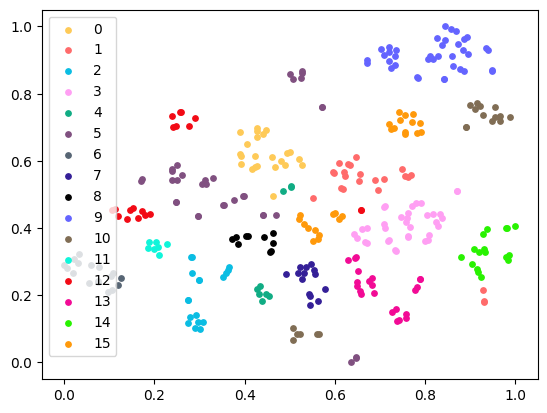

In [ ]:
# initialize a matplotlib plot
fig = plt.figure()
ax = fig.add_subplot(111)

# for every class, we'll add a scatter plot separately
for label in colors_per_class:
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(labels) if l == label]

    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)

    # convert the class color to matplotlib format
    color = np.array(colors_per_class[label], dtype=np.float) / 255

    # add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty, c=color, label=label, s=15)

# build a legend using the labels we set previously
ax.legend(loc='best')

# finally, show the plot
plt.show()

# Testing 2

In [ ]:
prediction_model = classification_module.load_from_checkpoint(best_checkpoint_path)
prediction_model.to(device)
prediction_model.freeze()

In [ ]:
testing_dir = os.path.join(input_dir, "test")
numSeen = 0
numCorrectTop1 = 0
numCorrectTop5 = 0
classWiseTop1 = {}
classWiseTop5 = {}

for i in pred_to_class:
  classWiseTop1[pred_to_class[i]] = 0
  classWiseTop5[pred_to_class[i]] = 0

for folder in os.listdir(testing_dir):
  new_path = os.path.join(testing_dir, folder)
  for file_name in os.listdir(new_path):
    video_path = os.path.join(new_path, file_name)

    start_sec = 0
    end_sec = start_sec + clip_duration

    video = EncodedVideo.from_path(video_path)

    video_data = video.get_clip(start_sec=start_sec, end_sec=end_sec)

    video_data = transform(video_data)

    inputs = video_data["video"]
    inputs = [i.to(device)[None, ...] for i in inputs]

    preds = prediction_model(inputs)

    preds = post_act(preds)
    pred_classes = preds.topk(k=5).indices

    pred_class_names = [pred_to_class[int(i)] for i in pred_classes[0]]

    numSeen += 1

    if pred_class_names[0] == folder:
        numCorrectTop1 += 1
        classWiseTop1[folder] += 1

    if folder in pred_class_names:
        numCorrectTop5 += 1
        classWiseTop5[folder] += 1

    print("Current Top1:", (numCorrectTop1 / numSeen) * 100, "%")
    print(video_path)
    print(folder)
    print(pred_class_names)

print("Evaluation Finished")
top1accuracy = (numCorrectTop1 / numSeen) * 100
top5accuracy = (numCorrectTop5 / numSeen) * 100
print("Top 1 Accuracy:", top1accuracy, "%")
print("Top 5 Accuracy:", top5accuracy, "%")

classWiseTop1_accuracy = {}
classWiseTop5_accuracy = {}
for i in classWiseTop1:
  classWiseTop1_accuracy[i] = (classWiseTop1[i] / test_class_values[i]) * 100
  classWiseTop5_accuracy[i] = (classWiseTop5[i] / test_class_values[i]) * 100

print(classWiseTop1_accuracy)
print(classWiseTop5_accuracy)

Current Top1: 0.0 %
/content/drive/MyDrive/Research/Muscle Video/Datasets/split_workout_videos_v1/test/bench press/bench press_57_0.mp4
bench press
['tricep Pushdown', 'chest fly machine', 'bench press', 'shoulder press', 'leg raises']
Current Top1: 0.0 %
/content/drive/MyDrive/Research/Muscle Video/Datasets/split_workout_videos_v1/test/bench press/bench press_57_1.mp4
bench press
['tricep Pushdown', 'chest fly machine', 'bench press', 'shoulder press', 'russian twist']
Current Top1: 33.33333333333333 %
/content/drive/MyDrive/Research/Muscle Video/Datasets/split_workout_videos_v1/test/bench press/bench press_18_0.mp4
bench press
['bench press', 'tricep Pushdown', 'shoulder press', 'chest fly machine', 'lat pulling']
Current Top1: 25.0 %
/content/drive/MyDrive/Research/Muscle Video/Datasets/split_workout_videos_v1/test/bench press/bench press_30_0.mp4
bench press
['chest fly machine', 'bench press', 'tricep Pushdown', 'shoulder press', 'deadlift']
Current Top1: 40.0 %
/content/drive/MyD